# Annotation Experiments

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

## Data Cleaning 

In [56]:
DATASETS  = {
    # "squadv2": {
    #     "human_files": [
    #         "results/squadv2/annotator_squadv2_kent.csv",
    #         "results/squadv2/annotator_squadv2_cyril.csv",
    #         "results/squadv2/annotator_squadv2_takuya.csv",
    #         "results/squadv2/annotator_squadv2_thomas.csv",
    #     ],
    #     "kent_file": "results/squadv2/annotator_squadv2_kent.csv",
    #     "gpt_files": [
    #         "results/squadv2/annotator_squadv2_1gpt4o.csv",
    #         "results/squadv2/annotator_squadv2_2gpt4o.csv",
    #     ],
    #     "annotator_prefix": "annotator_squadv2_",
    # },
    "techqa": {
        "human_files": [
            "results/techqa/annotator_techqa_kent.csv",
            "results/techqa/annotator_techqa_cyril.csv",
            "results/techqa/annotator_techqa_takuya.csv",
            "results/techqa/annotator_techqa_thomas.csv",
        ],
        "kent_file": "results/techqa/annotator_techqa_kent.csv",
        "gpt_files": [
            "results/techqa/annotator_techqa_1gpt4o.csv",
            "results/techqa/annotator_techqa_2gpt4o.csv",
        ],
        "annotator_prefix": "annotator_techqa_",
    },
}

STANDARD_COLS = ["item_id", "annotator", "valid", "reason", "notes", "type"]

def normalize_valid(series):
    """Map 1.0/0.0/strings/bools → 1/0; leave NaN as NaN (so blanks remain blanks)."""
    def _coerce(x):
        if pd.isna(x):
            return pd.NA
        s = str(x).strip().lower()
        try:
            f = float(s)
            if pd.isna(f):
                return pd.NA
            return 1 if f >= 0.5 else 0
        except Exception:
            if s in {"1", "true", "yes"}:
                return 1
            if s in {"0", "false", "no"}:
                return 0
            return pd.NA
    return series.apply(_coerce).astype("Int64")


def safe_rename(df, mapping):
    present = {k: v for k, v in mapping.items() if k in df.columns}
    return df.rename(columns=present)

def ensure_columns(df, columns):
    for c in columns:
        if c not in df.columns:
            df[c] = pd.NA
    return df[columns]

def annotator_from_filename(path, prefix):
    name = path.stem
    if name.startswith(prefix):
        return name[len(prefix):]
    return name

def normalize_human_files(files, annotator_prefix):
    for file in files:
        p = Path(file)
        df = pd.read_csv(p)

        df = safe_rename(df, {
            "is_valid": "valid",
            "aug_id": "item_id",
            "notes (optional)": "notes",
        })

        if "item_id" in df.columns:
            df["item_id"] = (
                df["item_id"]
                .astype(str)
                .str.strip() 
            )

        if "valid" in df.columns:
            df["valid"] = normalize_valid(df["valid"])
        else:
            df["valid"] = pd.NA

        df["annotator"] = annotator_from_filename(p, annotator_prefix)

        df = ensure_columns(df, STANDARD_COLS)

        df.to_csv(p, index=False)
        print(f"[ok] normalized human file: {p}")


def propagate_type_from_kent(kent_file, gpt_files):
    kent = pd.read_csv(kent_file)
    if "item_id" not in kent.columns:
        raise ValueError(f"Kent file missing item_id: {kent_file}")
    if "type" not in kent.columns:
        print(f"[warn] Kent file has no 'type' column: {kent_file} — skipping propagation.")
        return

    kent = kent.rename(columns={"aug_id": "item_id"})
    kent["item_id"] = (
        kent["item_id"]
        .astype(str)
        .str.strip() 
    )
    kent = kent[["item_id", "type"]].drop_duplicates()

    for g in gpt_files:
        p = Path(g)
        df = pd.read_csv(p)
        if "item_id" not in df.columns:
            print(f"[warn] GPT file has no item_id: {p} — cannot merge type; leaving as-is.")
            df.to_csv(p, index=False)
            continue

        df["item_id"] = (
            df["item_id"]
            .astype(str)
            .str.strip() 
        )

        merged = df.merge(kent, on="item_id", how="left", suffixes=("", "_kent"))
        if "type_kent" in merged.columns:
            merged["type"] = merged["type"].fillna(merged["type_kent"])
            merged = merged.drop(columns=["type_kent"])

        if "valid" in merged.columns:
            merged["valid"] = normalize_valid(merged["valid"])

        merged = ensure_columns(merged, STANDARD_COLS)
        merged.to_csv(p, index=False)
        print(f"[ok] merged type into GPT file: {p}")

In [57]:
for name, cfg in DATASETS.items():
    print(f"\n=== Processing {name} ===")
    normalize_human_files(cfg["human_files"], cfg["annotator_prefix"])
    propagate_type_from_kent(cfg["kent_file"], cfg["gpt_files"])


=== Processing techqa ===
[ok] normalized human file: results/techqa/annotator_techqa_kent.csv
[ok] normalized human file: results/techqa/annotator_techqa_cyril.csv
[ok] normalized human file: results/techqa/annotator_techqa_takuya.csv
[ok] normalized human file: results/techqa/annotator_techqa_thomas.csv
[ok] merged type into GPT file: results/techqa/annotator_techqa_1gpt4o.csv
[ok] merged type into GPT file: results/techqa/annotator_techqa_2gpt4o.csv


In [46]:
FILES = [
    "results/squadv2/annotator_squadv2_kent.csv",
    "results/squadv2/annotator_squadv2_cyril.csv",
    "results/squadv2/annotator_squadv2_takuya.csv",
    "results/squadv2/annotator_squadv2_thomas.csv",
    "results/squadv2/annotator_squadv2_1gpt4o.csv",
    "results/squadv2/annotator_squadv2_2gpt4o.csv",
]

ANNOTATORS = ["gpt4o_1", "gpt4o_2", "kent", "cyril", "thomas", "takuya"]  
ROW_ORDER = ["Semantic", "Syntactic", "Lexical"]  

TYPE_MAP = {
    "SEM": "Semantic", "SEMANTIC": "Semantic",
    "SYN": "Syntactic", "SYNTACTIC": "Syntactic",
    "LEX": "Lexical",   "LEXICAL": "Lexical",
}

REASON_COLORS = {
    "SPAN_MISSING": "#f8b4b4",
    "HALLUCINATION": "#9aa0a6",
    "AMBIGUOUS": "#5f6368",
    "OUT_OF_SCOPE": "#b00020",
    "DUPLICATE": "#8d6e63",
    "OTHER": "#1b5e20",
}
FALLBACK_COLOR = "#FFFFFF"

## Plot Consensus SQuADv2

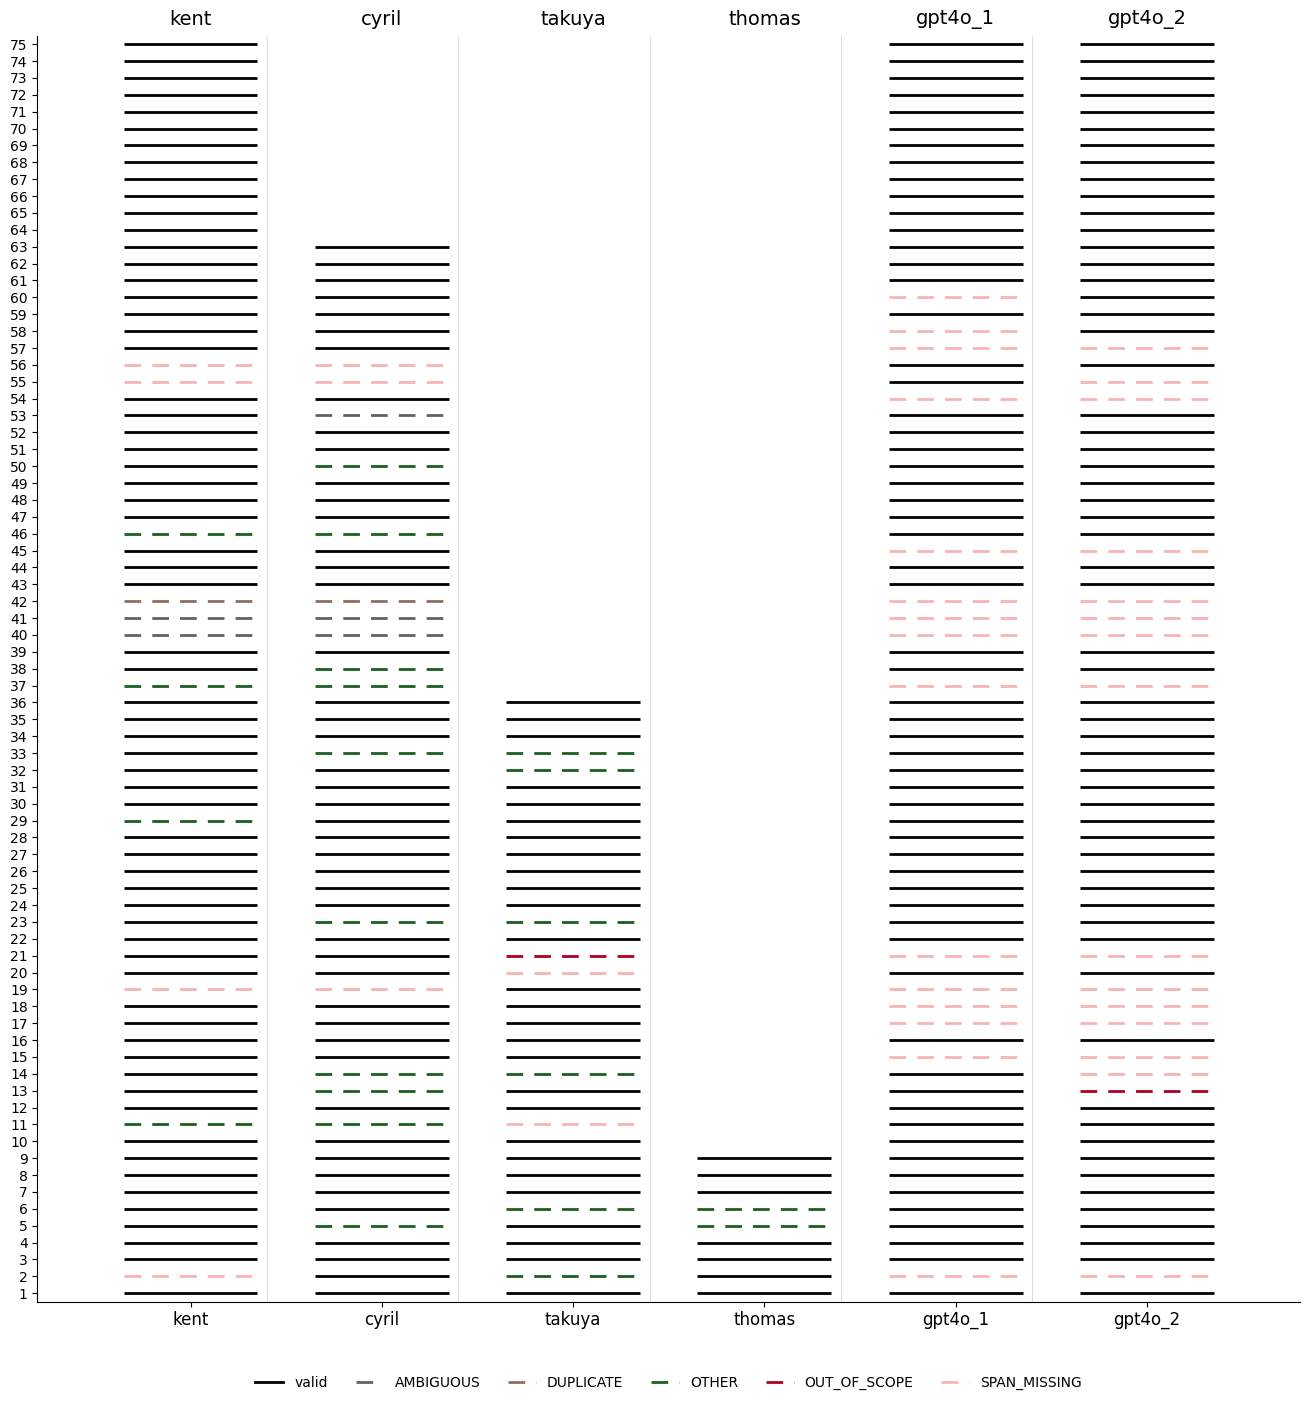

In [43]:
dfs, labels = [], []
for f in FILES:
    df = pd.read_csv(f)
    df.columns = [c.strip() for c in df.columns]
    df["valid"] = pd.to_numeric(df["valid"], errors="coerce").fillna(0.0)
    df["reason"] = df.get("reason", "").fillna("").astype(str).str.strip()
    dfs.append(df)
    if "annotator" in df.columns and df["annotator"].notna().any():
        labels.append(str(df["annotator"].iloc[0]))
    else:
        labels.append(Path(f).stem)

LIMIT = 75
dfs = [df.head(LIMIT) for df in dfs]
max_len = max(len(df) for df in dfs)
n_cols = len(dfs)

fig_w = max(7.0, 2.2 * n_cols)
fig_h = max(5.5, min(14.0, 0.22 * max_len + 3))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

half_width = 0.35

xs = list(range(n_cols))

for col_idx, df in enumerate(dfs):
    x_left  = xs[col_idx] - half_width
    x_right = xs[col_idx] + half_width

    for i, row in enumerate(df.itertuples(index=False), start=1):
        if float(row.valid) == 1.0:
            ax.hlines(y=i, xmin=x_left, xmax=x_right,
                      colors="black", linestyles="solid", linewidth=2)
        else:
            color = REASON_COLORS.get(row.reason, FALLBACK_COLOR)
            ax.hlines(y=i, xmin=x_left, xmax=x_right,
                      colors=color, linestyles=(0, (6, 4)), linewidth=2)

ax.set_xlim(-0.8, n_cols - 0.2)
ax.set_ylim(0.5, max_len + 0.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticks(range(1, max_len + 1))
ax.set_ylabel("")   
ax.set_xlabel("")  

for x in xs[1:]:
    ax.vlines(x - 0.6, 0.5, max_len + 0.5, color="#dddddd", linewidth=0.8, zorder=0)

for x, label in zip(xs, labels):
    ax.text(x, max_len + 0.9, label, ha="center", va="bottom", fontsize=14)

handles = [Line2D([0], [0], color="black", lw=2, linestyle="solid", label="valid")]
seen_reasons = set()
for df in dfs:
    seen_reasons.update(df.loc[df["valid"] != 1.0, "reason"].unique().tolist())
seen_reasons = [r for r in seen_reasons if isinstance(r, str) and r.strip()]
for r in sorted(seen_reasons):
    handles.append(Line2D([0], [0], color=REASON_COLORS.get(r, FALLBACK_COLOR),
                          lw=2, linestyle=(0, (6, 4)), label=r))
leg = ax.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.08),
                ncol=min(6, 1 + len(seen_reasons)), frameon=False)

for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

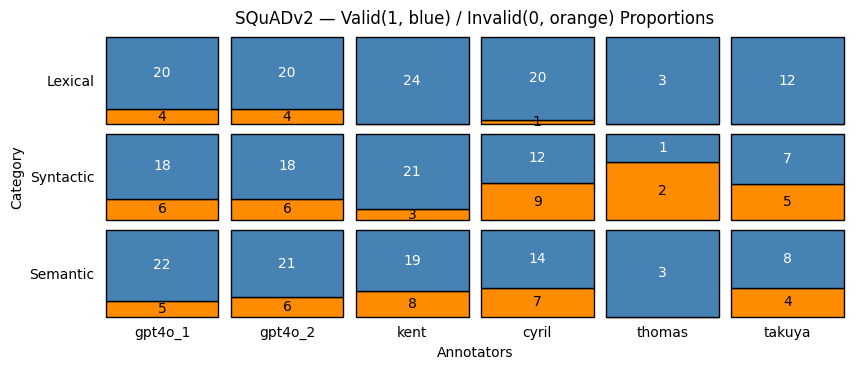

In [52]:
def normalize_valid(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    try:
        f = float(s)
        return 1 if f >= 0.5 else 0
    except Exception:
        if s in {"1", "true", "yes"}: return 1
        if s in {"0", "false", "no"}:  return 0
        return np.nan

def normalize_type(t):
    if pd.isna(t): return ""
    return TYPE_MAP.get(str(t).strip().upper(), str(t).strip().title())

def load_all(files):
    rows = []
    for f in files:
        p = Path(f)
        df = pd.read_csv(p)
        df = df.rename(columns={
            "is_valid": "valid",
            "aug_id": "item_id",
            "notes (optional)": "notes",
        })
        if "annotator" in df.columns:
            ann = df["annotator"] 
        else:
            ann = pd.Series([p.stem] * len(df))

        rec = pd.DataFrame({
            "annotator": ann,
            "valid": df.get("valid", pd.Series([np.nan]*len(df))).map(normalize_valid),
            "type": df.get("type", ""),
        })
        rec["type"] = rec["type"].map(normalize_type)
        rows.append(rec)
    out = pd.concat(rows, ignore_index=True)
    out = out[out["type"].isin(ROW_ORDER)]
    out = out[out["annotator"].notna()]
    return out

def build_counts(df, annotators):
    d = df.copy()
    d["valid"] = d["valid"].fillna(-1) 
    d = d[d["valid"].isin([0,1])]     
    g = d.groupby(["type", "annotator", "valid"]).size().rename("count").reset_index()

    idx = pd.MultiIndex.from_product([ROW_ORDER, annotators, [0,1]], names=["type","annotator","valid"])
    g = g.set_index(["type","annotator","valid"]).reindex(idx, fill_value=0).reset_index()
    return g

def plot_tiles(counts: pd.DataFrame, annotators, cell_w=0.9, cell_h=0.9, fontsize=10):
    c0 = (
        counts[counts["valid"] == 0]
        .pivot(index="type", columns="annotator", values="count")
        .reindex(index=ROW_ORDER, columns=annotators)
        .fillna(0)
        .astype(int)
    )
    c1 = (
        counts[counts["valid"] == 1]
        .pivot(index="type", columns="annotator", values="count")
        .reindex(index=ROW_ORDER, columns=annotators)
        .fillna(0)
        .astype(int)
    )

    # sanity check 
    # print("[debug] c0 (invalid) matrix:\n", c0)
    # print("[debug] c1 (valid)   matrix:\n", c1)

    fig, ax = plt.subplots(figsize=(1.2 * len(annotators) + 1.5, 3.8))

    row_labels_plot = ROW_ORDER
    ann2x = {a: i for i, a in enumerate(annotators)}
    
    row2y = {r: i for i, r in enumerate(row_labels_plot)}
    ax.set_yticks(range(len(row_labels_plot)))
    ax.set_yticklabels(row_labels_plot)

    for r in row_labels_plot:
        for a in annotators:
            y = row2y[r]
            x = ann2x[a]
            c0_ = int(c0.loc[r, a]) if not np.isnan(c0.loc[r, a]) else 0
            c1_ = int(c1.loc[r, a]) if not np.isnan(c1.loc[r, a]) else 0
            total = max(c0_ + c1_, 1)

            h0 = (c0_ / total) * cell_h  
            h1 = (c1_ / total) * cell_h  

            # bottom: invalid (orange)
            ax.add_patch(Rectangle((x - cell_w / 2, y - cell_h / 2), cell_w, h0,
                                   facecolor="darkorange", edgecolor="black"))
            # top: valid (blue)
            ax.add_patch(Rectangle((x - cell_w / 2, y - cell_h / 2 + h0), cell_w, h1,
                                   facecolor="steelblue", edgecolor="black"))

            if c0_ > 0:
                ax.text(x, y - cell_h / 2 + h0 / 2, str(c0_),
                        ha="center", va="center", fontsize=fontsize, color="black")
            if c1_ > 0:
                ax.text(x, y - cell_h / 2 + h0 + h1 / 2, str(c1_),
                        ha="center", va="center", fontsize=fontsize, color="white")

    ax.set_xlim(-0.5, len(annotators) - 0.5)
    ax.set_ylim(-0.5, len(ROW_ORDER) - 0.5)
    ax.set_xticks(range(len(annotators)))
    ax.set_xticklabels(annotators)
    ax.set_yticks(range(len(ROW_ORDER)))
    ax.set_yticklabels(row_labels_plot)

    for s in ax.spines.values():
        s.set_visible(False)
    ax.tick_params(length=0)

    ax.set_xlabel("Annotators")
    ax.set_ylabel("Category")
    ax.set_title("SQuADv2 — Valid(1, blue) / Invalid(0, orange) Proportions")
    plt.tight_layout()

df = load_all(FILES)
counts = build_counts(df, ANNOTATORS)
plot_tiles(counts, ANNOTATORS)

## Plot Consensus TechQA

In [58]:
FILES = [
    "results/techqa/annotator_techqa_kent.csv",
    "results/techqa/annotator_techqa_cyril.csv",
    "results/techqa/annotator_techqa_takuya.csv",
    "results/techqa/annotator_techqa_thomas.csv",
    "results/techqa/annotator_techqa_1gpt4o.csv",
    "results/techqa/annotator_techqa_2gpt4o.csv",
]

REASON_COLORS = {
    "SPAN_MISSING": "#f8b4b4",
    "HALLUCINATION": "#9aa0a6",
    "AMBIGUOUS": "#5f6368",
    "OUT_OF_SCOPE": "#b00020",
    "DUPLICATE": "#8d6e63",
    "OTHER": "#1b5e20",
}
FALLBACK_COLOR = "#FFFFFF"

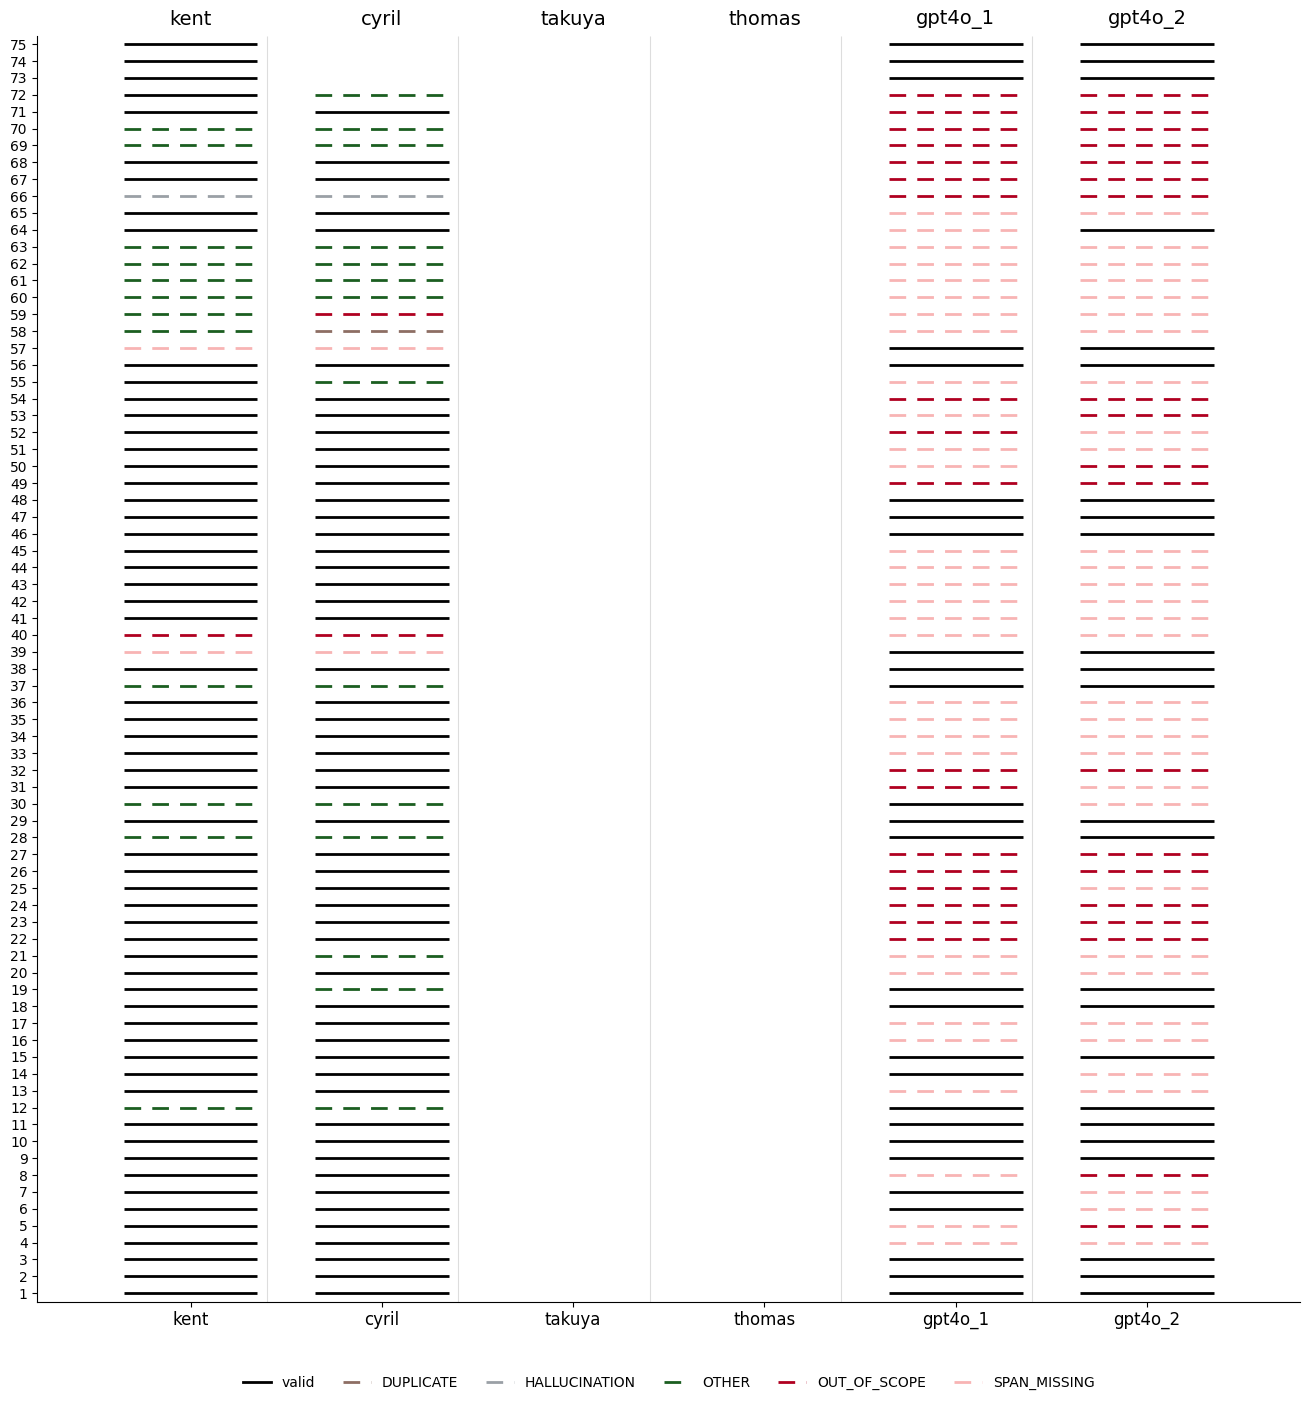

In [61]:
dfs, labels = [], []
for f in FILES:
    df = pd.read_csv(f)
    df.columns = [c.strip() for c in df.columns]
    df["valid"] = pd.to_numeric(df["valid"], errors="coerce").fillna(0.0)
    df["reason"] = df.get("reason", "").fillna("").astype(str).str.strip()
    dfs.append(df)
    if "annotator" in df.columns and df["annotator"].notna().any():
        labels.append(str(df["annotator"].iloc[0]))
    else:
        labels.append(Path(f).stem)

LIMIT = 75
dfs = [df.head(LIMIT) for df in dfs]
max_len = max(len(df) for df in dfs)
n_cols = len(dfs)

fig_w = max(7.0, 2.2 * n_cols)
fig_h = max(5.5, min(14.0, 0.22 * max_len + 3))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

half_width = 0.35

xs = list(range(n_cols))

for col_idx, df in enumerate(dfs):
    x_left  = xs[col_idx] - half_width
    x_right = xs[col_idx] + half_width

    for i, row in enumerate(df.itertuples(index=False), start=1):
        if float(row.valid) == 1.0:
            ax.hlines(y=i, xmin=x_left, xmax=x_right,
                      colors="black", linestyles="solid", linewidth=2)
        else:
            color = REASON_COLORS.get(row.reason, FALLBACK_COLOR)
            ax.hlines(y=i, xmin=x_left, xmax=x_right,
                      colors=color, linestyles=(0, (6, 4)), linewidth=2)

ax.set_xlim(-0.8, n_cols - 0.2)
ax.set_ylim(0.5, max_len + 0.5)
ax.set_xticks(xs)
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticks(range(1, max_len + 1))
ax.set_ylabel("")   
ax.set_xlabel("")  

for x in xs[1:]:
    ax.vlines(x - 0.6, 0.5, max_len + 0.5, color="#dddddd", linewidth=0.8, zorder=0)

for x, label in zip(xs, labels):
    ax.text(x, max_len + 0.9, label, ha="center", va="bottom", fontsize=14)

handles = [Line2D([0], [0], color="black", lw=2, linestyle="solid", label="valid")]
seen_reasons = set()
for df in dfs:
    seen_reasons.update(df.loc[df["valid"] != 1.0, "reason"].unique().tolist())
seen_reasons = [r for r in seen_reasons if isinstance(r, str) and r.strip()]
for r in sorted(seen_reasons):
    handles.append(Line2D([0], [0], color=REASON_COLORS.get(r, FALLBACK_COLOR),
                          lw=2, linestyle=(0, (6, 4)), label=r))
leg = ax.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.08),
                ncol=min(6, 1 + len(seen_reasons)), frameon=False)

for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

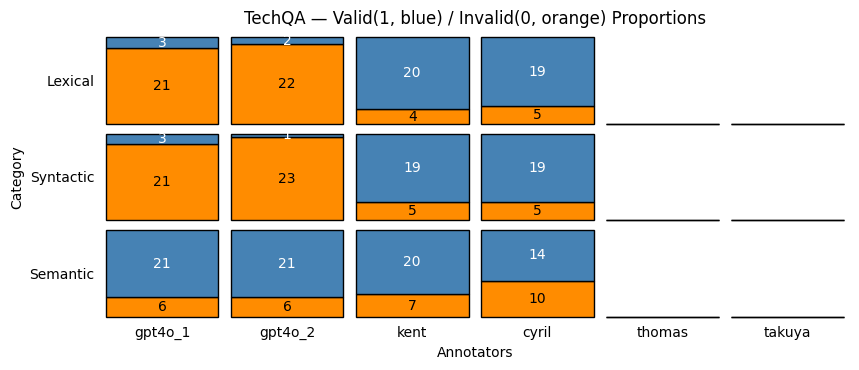

In [62]:
def normalize_valid(x):
    if pd.isna(x): 
        return np.nan
    s = str(x).strip().lower()
    try:
        f = float(s)
        return 1 if f >= 0.5 else 0
    except Exception:
        if s in {"1", "true", "yes"}: return 1
        if s in {"0", "false", "no"}:  return 0
        return np.nan

def normalize_type(t):
    if pd.isna(t): return ""
    return TYPE_MAP.get(str(t).strip().upper(), str(t).strip().title())

def load_all(files):
    rows = []
    for f in files:
        p = Path(f)
        df = pd.read_csv(p)
        df = df.rename(columns={
            "is_valid": "valid",
            "aug_id": "item_id",
            "notes (optional)": "notes",
        })
        if "annotator" in df.columns:
            ann = df["annotator"] 
        else:
            ann = pd.Series([p.stem] * len(df))

        rec = pd.DataFrame({
            "annotator": ann,
            "valid": df.get("valid", pd.Series([np.nan]*len(df))).map(normalize_valid),
            "type": df.get("type", ""),
        })
        rec["type"] = rec["type"].map(normalize_type)
        rows.append(rec)
    out = pd.concat(rows, ignore_index=True)
    out = out[out["type"].isin(ROW_ORDER)]
    out = out[out["annotator"].notna()]
    return out

def build_counts(df, annotators):
    d = df.copy()
    d["valid"] = d["valid"].fillna(-1) 
    d = d[d["valid"].isin([0,1])]     
    g = d.groupby(["type", "annotator", "valid"]).size().rename("count").reset_index()

    idx = pd.MultiIndex.from_product([ROW_ORDER, annotators, [0,1]], names=["type","annotator","valid"])
    g = g.set_index(["type","annotator","valid"]).reindex(idx, fill_value=0).reset_index()
    return g

def plot_tiles(counts: pd.DataFrame, annotators, cell_w=0.9, cell_h=0.9, fontsize=10):
    c0 = (
        counts[counts["valid"] == 0]
        .pivot(index="type", columns="annotator", values="count")
        .reindex(index=ROW_ORDER, columns=annotators)
        .fillna(0)
        .astype(int)
    )
    c1 = (
        counts[counts["valid"] == 1]
        .pivot(index="type", columns="annotator", values="count")
        .reindex(index=ROW_ORDER, columns=annotators)
        .fillna(0)
        .astype(int)
    )

    # sanity check 
    # print("[debug] c0 (invalid) matrix:\n", c0)
    # print("[debug] c1 (valid)   matrix:\n", c1)

    fig, ax = plt.subplots(figsize=(1.2 * len(annotators) + 1.5, 3.8))

    row_labels_plot = ROW_ORDER
    ann2x = {a: i for i, a in enumerate(annotators)}
    
    row2y = {r: i for i, r in enumerate(row_labels_plot)}
    ax.set_yticks(range(len(row_labels_plot)))
    ax.set_yticklabels(row_labels_plot)

    for r in row_labels_plot:
        for a in annotators:
            y = row2y[r]
            x = ann2x[a]
            c0_ = int(c0.loc[r, a]) if not np.isnan(c0.loc[r, a]) else 0
            c1_ = int(c1.loc[r, a]) if not np.isnan(c1.loc[r, a]) else 0
            total = max(c0_ + c1_, 1)

            h0 = (c0_ / total) * cell_h  
            h1 = (c1_ / total) * cell_h  

            # bottom: invalid (orange)
            ax.add_patch(Rectangle((x - cell_w / 2, y - cell_h / 2), cell_w, h0,
                                   facecolor="darkorange", edgecolor="black"))
            # top: valid (blue)
            ax.add_patch(Rectangle((x - cell_w / 2, y - cell_h / 2 + h0), cell_w, h1,
                                   facecolor="steelblue", edgecolor="black"))

            if c0_ > 0:
                ax.text(x, y - cell_h / 2 + h0 / 2, str(c0_),
                        ha="center", va="center", fontsize=fontsize, color="black")
            if c1_ > 0:
                ax.text(x, y - cell_h / 2 + h0 + h1 / 2, str(c1_),
                        ha="center", va="center", fontsize=fontsize, color="white")

    ax.set_xlim(-0.5, len(annotators) - 0.5)
    ax.set_ylim(-0.5, len(ROW_ORDER) - 0.5)
    ax.set_xticks(range(len(annotators)))
    ax.set_xticklabels(annotators)
    ax.set_yticks(range(len(ROW_ORDER)))
    ax.set_yticklabels(row_labels_plot)

    for s in ax.spines.values():
        s.set_visible(False)
    ax.tick_params(length=0)

    ax.set_xlabel("Annotators")
    ax.set_ylabel("Category")
    ax.set_title("TechQA — Valid(1, blue) / Invalid(0, orange) Proportions")
    plt.tight_layout()

df = load_all(FILES)
counts = build_counts(df, ANNOTATORS)
plot_tiles(counts, ANNOTATORS)